In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()


chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [3]:
import random
random.shuffle(words)
random.seed(42)

In [4]:
block_size = 3

def build_dataset (words):
    X, Y = [], []

    for word in words:
        context = [0]*block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [6]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [7]:
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [8]:
torch.manual_seed(42);

In [9]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0 /  200000: 3.3168
  10000 /  200000: 2.1685
  20000 /  200000: 1.8821
  30000 /  200000: 2.0257


KeyboardInterrupt: 

learning rate decay allows to reduce a lot of loss at once here it is around 150.

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 37783

In [12]:
for layer in layers:
    layer.training = False

In [13]:
@torch.no_grad()

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.174443483352661
val 2.2091314792633057


In [14]:
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

In [15]:
class Flatten:

    def __call__(self, x: torch.Tensor):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

In [16]:
class Sequential:

    def __init__(self, layers: list):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [25]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break

      0 /  200000: 3.5226


learning rate decay allows to reduce a lot of loss at once here it is around 150.

In [27]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1

In [28]:
for layer in model.layers:
    layer.training = False

In [29]:
@torch.no_grad()

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.486837387084961
val 3.4916512966156006


In [30]:
# Sampling

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        #forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

xciyxqqkrfjleojnhnngnnx.
frmeqs.
yfhhbyrmvyjqi.
zcxhsoambxxkqxlwlxgeoabxxt.
vximkbdsvzqfdxljdsfuojueercakkotujsaekqkezqhavwmslcmleunah.
llwrtbelzdudqhd.
gkrxftapztoo.
bk.
a.
ysoltlyfyypvjjjevveunpdgecahdyybbnukjqakqaeqkbap.
vpmtbbphcdyqhyxhcvpilggqxqqpw.
elwevzvzamhaxrjjcvgtabvafzcjwvsb.
.
teyxrxjfpaekkdspvakfzyijjdqginxnizbxqbxxvap.
pddpyqd.
qrfrjgvdjnljqjwbdjjsvjc.
cndcfsmmebgo.
gwibofcwdrowaubuowbtrejeix.
tmkpukleocqclfhdzezvqjig.
ujdvvb.


[Resume Here](https://youtu.be/t3YJ5hKiMQ0?t=1069)

In [53]:
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n 

    def __call__(self, x: torch.Tensor):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [54]:
block_size = 8

def build_dataset (words):
    X, Y = [], []

    for word in words:
        context = [0]*block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [41]:
e = torch.randn(4, 8, 10)
e.view(-1, 10).shape

torch.Size([32, 10])

In [78]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True) ## Maintaining the shape of the data
evar = e.var((0, 1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [79]:
n_embd = 24
n_hidden = 128

C = torch.randn((vocab_size, n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [81]:
ix = torch.randint(0,Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 19,  8,  1],
        [ 0,  0,  0, 12,  5,  5, 12,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  7],
        [ 0,  0,  0,  0,  0,  0, 24,  1]])

In [36]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [37]:
model.layers[1].out.shape

torch.Size([4, 80])

In [38]:
model.layers[2].out.shape

torch.Size([4, 200])

In [82]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [62]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
Flatten : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [83]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0 /  200000: 3.3343
  10000 /  200000: 2.3526
  20000 /  200000: 2.1197
  30000 /  200000: 1.8482
  40000 /  200000: 2.1065
  50000 /  200000: 1.9617
  60000 /  200000: 1.9157
  70000 /  200000: 1.9286
  80000 /  200000: 2.2526
  90000 /  200000: 2.3734
 100000 /  200000: 2.0649
 110000 /  200000: 1.6968
 120000 /  200000: 1.6417
 130000 /  200000: 1.9372
 140000 /  200000: 1.6179
 150000 /  200000: 1.9631
 160000 /  200000: 1.7407
 170000 /  200000: 1.3027
 180000 /  200000: 1.9745
 190000 /  200000: 1.8039


learning rate decay allows to reduce a lot of loss at once here it is around 150.

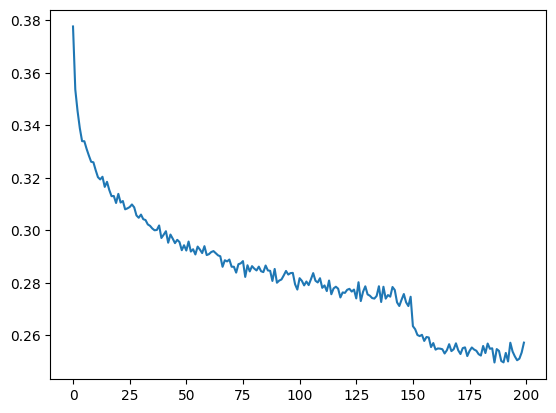

In [84]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.show()

In [85]:
for layer in model.layers:
    layer.training = False

In [86]:
@torch.no_grad()

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7676081657409668
val 1.9949308633804321


[Reference this part](https://youtu.be/t3YJ5hKiMQ0?t=2752)

In [87]:
# Sampling

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        #forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

millakyn.
kiyani.
alizzna.
ellison.
venicio.
jaycel.
matae.
yuvani.
amyro.
cavanel.
rhylon.
aubrey.
noah.
anveo.
lolette.
zamera.
ccanico.
noa.
dayor.
abbas.
